## Transfer Learning

### initialize the libraries

In [4]:
import wandb
from wandb.keras import WandbCallback
run = wandb.init(project='baselines_df4', entity='gijstimmerij', reinit=True)


In [5]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from tsai.all import SlidingWindowPanel, check_data
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [6]:
from importlib.machinery import SourceFileLoader
somemodule = SourceFileLoader(
    'tcn', r'C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\keras-tcn-master\tcn\tcn.py').load_module()


In [74]:
dataset = 'FD004'
num_engines = 50
columns = ["id", "cycle", "op1", "op2", "op3", "sensor1", "sensor2", "sensor3", "sensor4", "sensor5", "sensor6", "sensor7", "sensor8",
           "sensor9", "sensor10", "sensor11", "sensor12", "sensor13", "sensor14", "sensor15", "sensor16", "sensor17", "sensor18", "sensor19", "sensor20", "sensor21", "sensor22", "sensor23"]

train = pd.read_csv(
    fr"C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData\train_{dataset}.txt", sep=" ", names=columns)
test = pd.read_csv(
    fr"C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData\test_{dataset}.txt", sep=" ", names=columns)
test_results = pd.read_csv(
    fr"C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData\RUL_{dataset}.txt", sep=" ", header=None)


In [75]:
train


,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,NaN,NaN
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,NaN,NaN
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,NaN,NaN
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,NaN,NaN
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234,NaN,NaN
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151,NaN,NaN
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270,NaN,NaN
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774,NaN,NaN


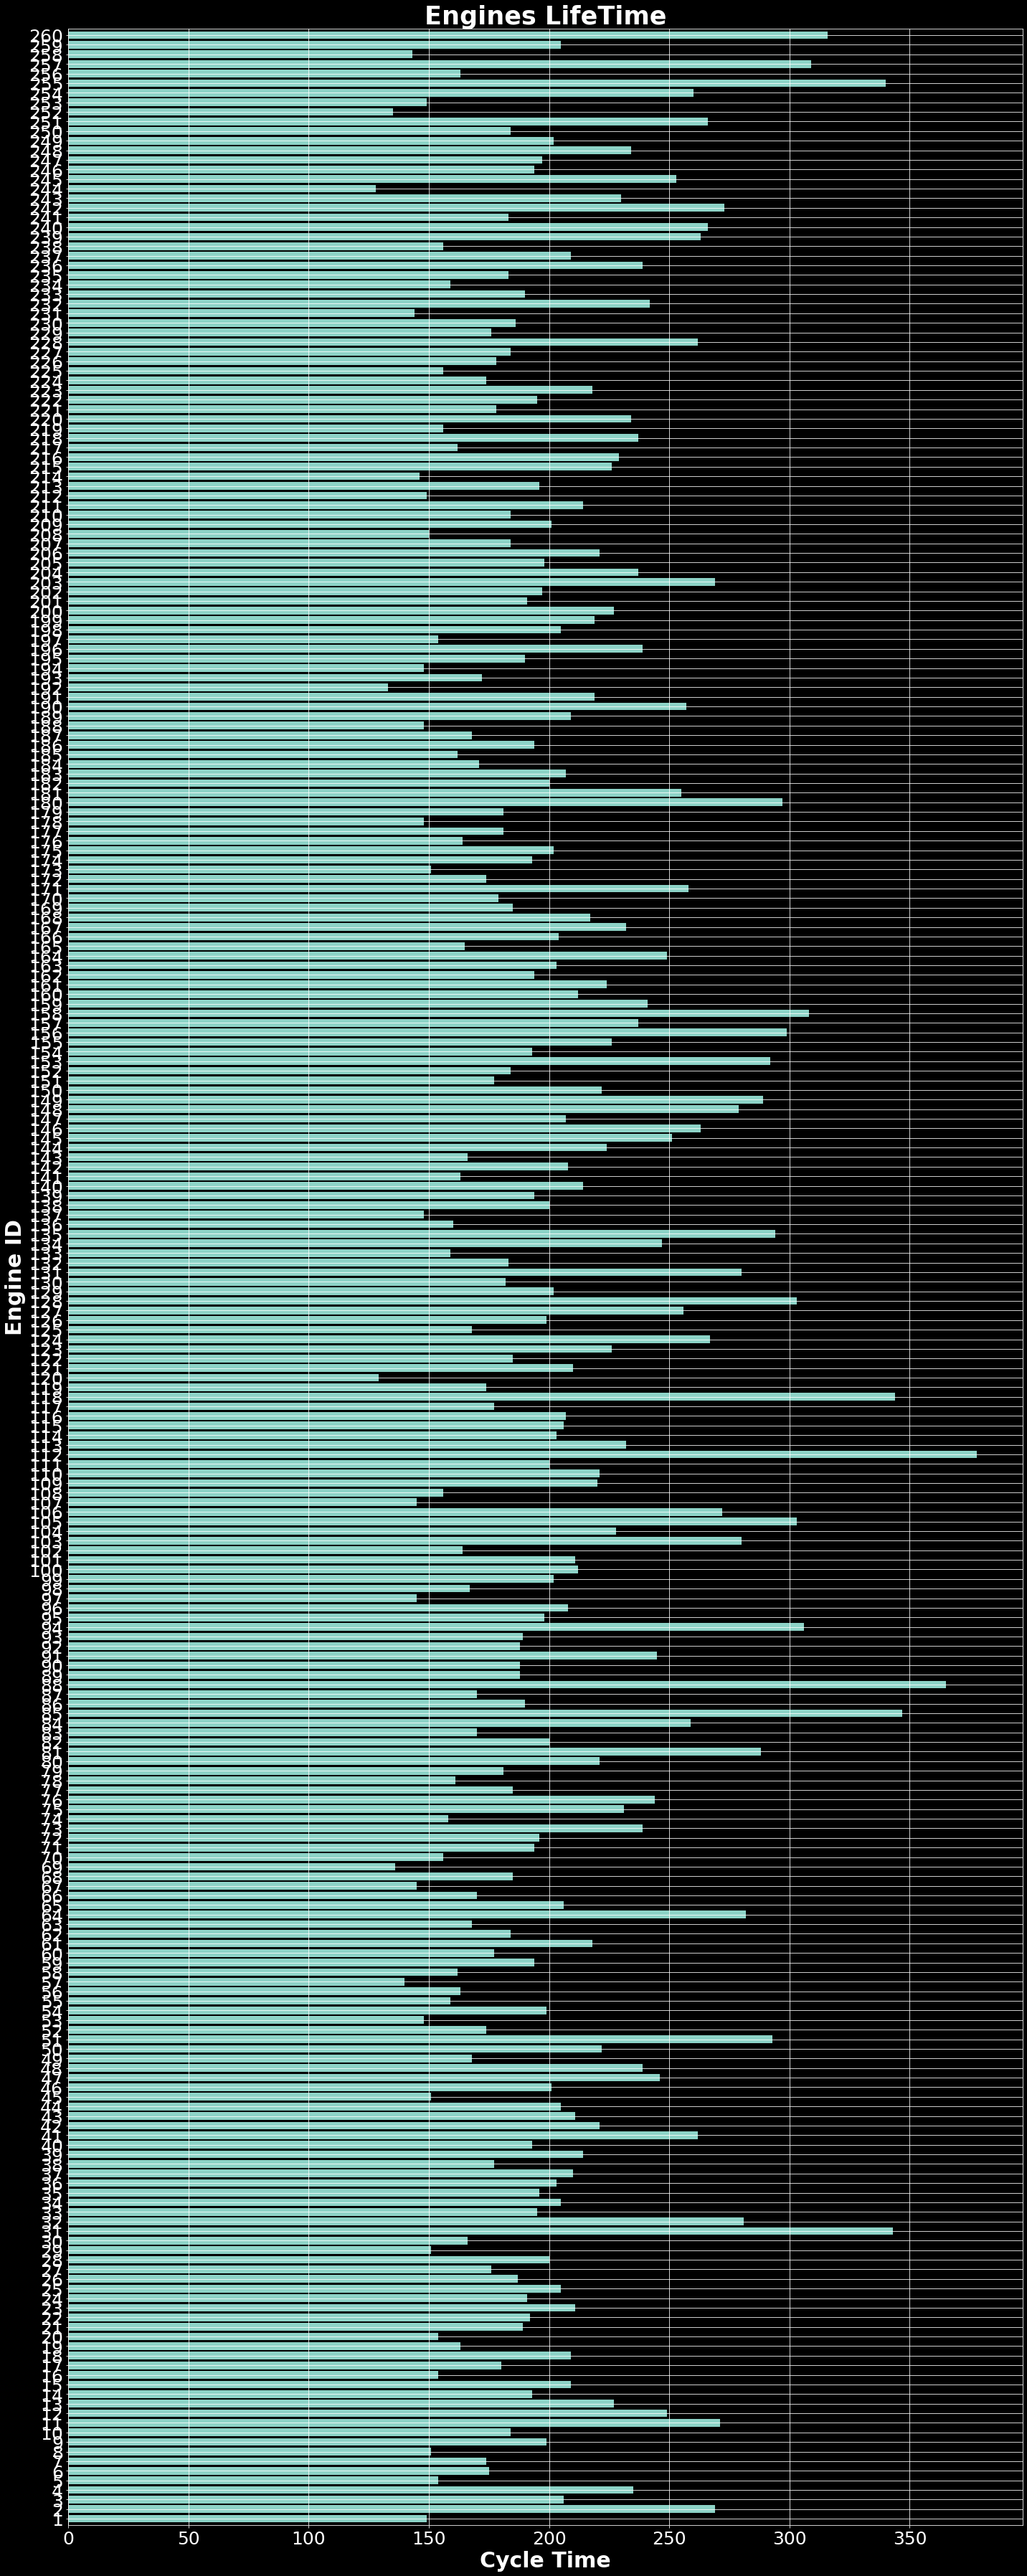

In [50]:
plt.style.use('dark_background')
plt.figure(figsize=(20, 50))
ax = train.groupby('id')['cycle'].max().plot(
    kind='barh', width=0.8, stacked=True, align='center', rot=0)
plt.title('Engines LifeTime', fontweight='bold', size=35)
plt.xlabel('Cycle Time', fontweight='bold', size=30)
plt.xticks(size=25)
plt.ylabel('Engine ID', fontweight='bold', size=30)
plt.yticks(size=25)
plt.grid(True)
plt.tight_layout()
plt.show()


## Data preparation

In [76]:
df_train = train.drop(["sensor22", "sensor23"], axis=1)
df_test = test.drop(["sensor22", "sensor23"], axis=1)
df_train['remaining_cycle'] = df_train.groupby(
    ['id'])['cycle'].transform(max)-df_train['cycle']


### Prepare test set

## Visualize sensor data

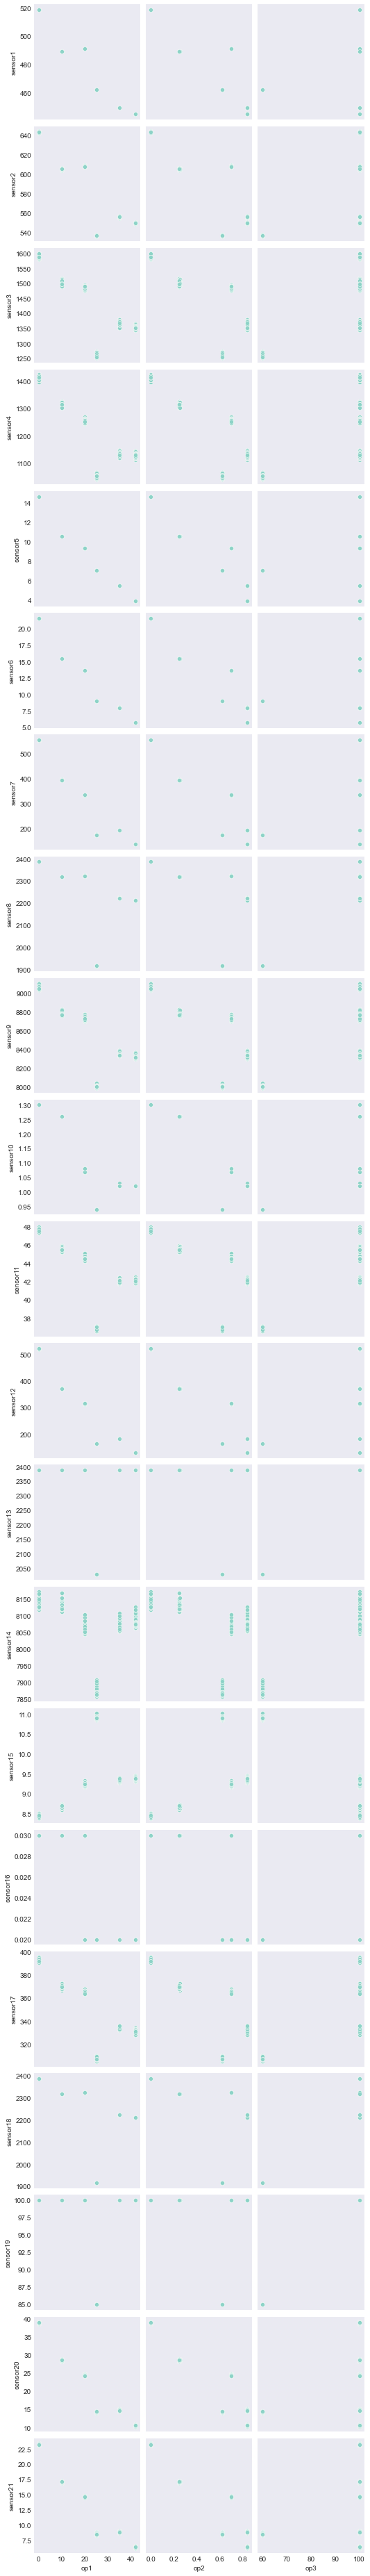

In [6]:
op_set = ["op"+str(i) for i in range(1, 4)]
sensor = ["sensor"+str(i) for i in range(1, 22)]

plt.style.use('seaborn-dark')
ax = sb.pairplot(test.query("cycle"), x_vars=op_set,
                 y_vars=sensor, palette="husl")


### Delete the useless variables

### Create smaller dataset with less engines

In [77]:
df_train_50 = df_train[df_train['id'] <= 80]
df_reduced = df_train[df_train['id'] <= 5]
df_test_50 = df_train[(df_train['id'] > 80) & (df_train['id'] <= 100)]


### Normalize the data

In [78]:
gen = MinMaxScaler(feature_range=(0, 1))
pt = PowerTransformer()

data = gen.fit_transform(df_train_50[['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
                                      'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
                                      'sensor17', 'sensor20', 'sensor21']])
data = pd.DataFrame(data)

scaled_X_train = pt.fit_transform(data)
#scaled_X_train = data

scaled_df_train = pd.DataFrame(scaled_X_train)
scaled_df_train['RUL'] = df_train_50.remaining_cycle
scaled_df_train['id'] = df_train_50.id
scaled_df_train


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,RUL,id
0,1.263034,0.984894,-0.757006,-0.662174,-0.694368,-1.213541,-0.409665,-0.593243,-0.470713,-1.204390,0.416395,-0.187958,0.294353,-0.591168,-1.239656,-1.241414,320,1
1,-0.322252,0.259678,0.858367,0.613203,0.458040,0.640171,0.676516,0.603594,0.253391,0.640520,0.406784,-0.598877,0.084747,0.536801,0.621901,0.626683,319,1
2,1.262950,0.990054,-0.787756,-0.665408,-0.648699,-1.200991,-0.409186,-0.608038,-0.479676,-1.206992,0.415655,-0.313800,0.386938,-0.631017,-1.269372,-1.222355,318,1
3,1.262659,0.984894,-0.798373,-0.685058,-0.637928,-1.204046,-0.409505,-0.589955,-0.473702,-1.204065,0.417506,-0.168661,0.299133,-0.671115,-1.256596,-1.223649,317,1
4,0.019877,-0.089108,-1.396694,-1.652283,-1.717213,-0.697727,-1.790421,-1.672497,-1.762036,-0.702185,-2.376433,-1.863224,1.710052,-1.671966,-0.606210,-0.536923,316,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19865,-0.322245,0.259211,0.899989,0.826151,0.688170,0.705738,0.688924,0.797615,0.678256,0.705163,0.449894,0.513578,-0.188908,0.767052,0.685019,0.680697,4,80
19866,-0.970360,-1.207958,0.855426,0.905352,1.031470,1.004830,0.629233,0.964588,1.034645,1.005839,0.446901,2.196914,-1.437750,0.989772,0.983446,0.985173,3,80
19867,-0.322299,0.258745,0.899224,0.803802,0.691566,0.709819,0.689273,0.793200,0.634084,0.708032,0.452889,0.602412,-0.188044,0.799317,0.657562,0.669080,2,80
19868,-0.322137,0.261545,0.899606,0.846579,0.732072,0.713613,0.690551,0.802682,0.586568,0.711595,0.453263,0.473460,-0.235320,0.734634,0.680890,0.690749,1,80


In [79]:
data = gen.transform(df_test_50[['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
                                 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
                                 'sensor17', 'sensor20', 'sensor21']])
data = pd.DataFrame(data)
scaled_df_test = pt.transform(data)
# scaled_df_test = data

scaled_df_test = pd.DataFrame(scaled_df_test)
scaled_df_test['RUL'] = df_test_50.remaining_cycle.reset_index(drop=True)
scaled_df_test['id'] = df_test_50.id.reset_index(drop=True)
scaled_df_test


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,RUL,id
0,-0.970223,-1.208370,0.833306,0.748568,0.950318,0.965433,0.621925,0.776227,0.648775,0.961979,0.420470,0.807479,-1.027056,0.799317,0.944643,0.941146,186,81
1,1.263011,0.984894,-0.774653,-0.583658,-0.565540,-1.191390,-0.409266,-0.565418,-0.437694,-1.187538,0.418247,-0.008539,0.277258,-0.591168,-1.224922,-1.202182,185,81
2,-1.566595,-1.596763,1.448016,1.490161,1.525673,1.508258,1.500565,1.512709,1.499981,1.509190,0.417877,0.964719,-1.512921,1.473383,1.506576,1.520416,184,81
3,-1.566680,-1.595535,1.449775,1.573715,1.488749,1.509097,1.499442,1.524582,1.608177,1.510352,0.419729,1.155822,-1.563354,1.502524,1.509182,1.516325,183,81
4,0.019314,-0.091987,-1.366122,-1.613255,-1.430814,-0.693287,-1.790294,-1.628360,-1.732157,-0.701528,-2.376426,-1.858649,1.712789,-1.671966,-0.554533,-0.552479,182,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4692,-1.566577,-1.597097,1.458803,1.650385,1.610918,1.546348,1.505200,1.679326,1.828874,1.544445,0.435706,2.348894,-2.054121,1.617897,1.544167,1.543737,4,100
4693,-0.970099,-1.208370,0.841633,0.895393,1.054125,1.003307,0.629690,0.973978,0.945739,1.003443,0.447275,2.115939,-1.377627,0.895206,0.984788,0.982356,3,100
4694,-0.321895,0.260144,0.888281,0.790308,0.676889,0.703582,0.689621,0.780623,0.612110,0.702875,0.449145,0.389253,-0.208694,0.767052,0.660916,0.672020,2,100
4695,-1.566629,-1.597765,1.457728,1.654247,1.607304,1.545044,1.505763,1.679848,1.919632,1.546168,0.435706,2.565509,-2.075921,1.589230,1.542488,1.542253,1,100


In [80]:
data = gen.fit_transform(df_reduced[['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
                                     'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
                                     'sensor17', 'sensor20', 'sensor21']])
data = pd.DataFrame(data)
data = np.nan_to_num(data)

scaled_X_reduced = pt.fit_transform(data)

scaled_df_reduced = pd.DataFrame(scaled_X_reduced)
scaled_df_reduced['RUL'] = df_reduced.remaining_cycle
scaled_df_reduced['id'] = df_reduced.id
scaled_df_reduced


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,RUL,id
0,1.279555,0.998483,-0.714916,-0.612551,-0.647034,-1.218217,-0.345329,-0.548452,-0.420385,-1.208820,0.446962,-0.160429,0.240941,-0.545391,-1.248196,-1.250532,320,1
1,-0.337816,0.251487,0.890673,0.644897,0.492636,0.679810,0.706214,0.630812,0.290396,0.680509,0.438884,-0.558354,0.035051,0.567659,0.657826,0.661716,319,1
2,1.279469,1.003819,-0.746132,-0.615765,-0.601583,-1.205010,-0.344860,-0.563138,-0.429211,-1.211561,0.446339,-0.281935,0.332007,-0.584953,-1.279430,-1.230547,318,1
3,1.279170,0.998483,-0.756914,-0.635296,-0.590867,-1.208225,-0.345173,-0.545189,-0.423329,-1.208478,0.447895,-0.141824,0.245640,-0.624779,-1.265999,-1.231904,317,1
4,0.009321,-0.105361,-1.368730,-1.603073,-1.671286,-0.679029,-1.730655,-1.627680,-1.701123,-0.683551,-2.215120,-1.805577,1.644879,-1.624670,-0.588002,-0.517836,316,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,1.279673,0.998483,-0.681158,-0.355041,-0.307800,-1.182144,-0.336632,-0.307613,-0.141425,-1.198569,0.482632,1.305542,0.397489,-0.428262,-1.270468,-1.262418,4,5
1390,0.008954,-0.108299,-1.314720,-1.439669,-1.270711,-0.680311,-1.728072,-1.360555,-1.524235,-0.681230,-2.214890,-1.588770,1.754100,-1.392133,-0.582944,-0.580806,3,5
1391,0.739839,1.005006,-0.438668,-0.235904,-0.340464,-0.448373,-0.246967,-0.198780,-0.212674,-0.438692,0.490826,0.873170,0.349981,-0.313385,-0.463315,-0.450971,2,5
1392,0.740171,1.008569,-0.413460,-0.257025,-0.320383,-0.445163,-0.246804,-0.185511,-0.200355,-0.444286,0.493036,0.786529,0.297492,-0.238004,-0.485755,-0.489541,1,5


### Apply a sliding windon panel to the data

In [81]:
window_len = 30
swp_X, swp_y = SlidingWindowPanel(window_len=window_len, unique_id_cols=[
                                  'id'], get_x=[i for i in range(16)], get_y=['RUL'], stride=1)(scaled_df_train)

swp_X_test, swp_y_test = SlidingWindowPanel(window_len=window_len, unique_id_cols=[
                                            'id'], get_x=[i for i in range(16)], get_y=['RUL'], stride=1)(scaled_df_test)


swp_X_reduced, swp_y_reduced = SlidingWindowPanel(window_len=window_len, unique_id_cols=[
                                                  'id'], get_x=[i for i in range(16)],
                                                  get_y=['RUL'], stride=1)(scaled_df_reduced)
check_data(swp_X, swp_y)


processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated
processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated
processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated
X      - shape: [17470 samples x 16 features x 30 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (17470,)  type: ndarray  dtype:int64  isnan: 0


In [82]:
dataset = 'df4'
np.save(f'Data/{dataset}/swpX', swp_X)
np.save(f'Data/{dataset}/swpy', swp_y)
np.save(f'Data/{dataset}/swpX_test', swp_X_test)
np.save(f'Data/{dataset}/swpy_test', swp_y_test)
np.save(f'Data/{dataset}/swpX_reduced', swp_X_reduced)
np.save(f'Data/{dataset}/swpy_reduced', swp_y_reduced)


In [115]:
dataset = 'df2'
swp_X = np.load(f'Data/{dataset}/swpX.npy')
swp_y = np.load(f'Data/{dataset}/swpy.npy')
swp_X_test = np.load(f'Data/{dataset}/swpX_test.npy')
swp_y_test = np.load(f'Data/{dataset}/swpy_test.npy')
swp_X_reduced = np.load(f'Data/{dataset}/swpX_reduced.npy')
swp_y_reduced = np.load(f'Data/{dataset}/swpy_reduced.npy')

In [117]:
swp_X_reduced = np.load(f'Data/{dataset}/swpX_reducedn10.npy')
swp_y_reduced = np.load(f'Data/{dataset}/swpy_reducedn10.npy')

In [17]:
output_path = fr'C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\output-tcn-tsai\50_50_nopt\{dataset}'
data_path = r'C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData'


In [58]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))


In [64]:
import tensorflow as tf
from tcn import TCN
from tensorflow.keras.regularizers import l2
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [107]:
def compile_model(swp_X):

    # output tcn2
    nb_features = swp_X.shape[2]

    i = Input(shape=(swp_X.shape[1], nb_features))

    m = TCN(nb_filters=64, kernel_size=3, dropout_rate=0.4, dilations=[
            1, 2, 4, 8, 16, 32], return_sequences=True, activation='relu')(i)
    m = TCN(nb_filters=32, dropout_rate=0.4, kernel_size=3, dilations=[
            1, 2, 4, 8, 16, 32], return_sequences=False, activation='relu')(m)
    m = Dense(1, activation='linear')(m)
    model = Model(inputs=[i], outputs=[m])

    model.summary()
    opt = tf.keras.optimizers.Adam()
    model.compile(loss=root_mean_squared_error, optimizer=opt,
                  metrics=['mae', root_mean_squared_error])
    return model


In [93]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, min_lr=1e-5, verbose=1)


In [118]:
group = 'df2_reducedn10_do.4'
swpX = swp_X_reduced
swpy = swp_y_reduced.astype('float')
for i in range(3):
    # model_path = output_path+fr'\model_{group}_{i}.h5'
    run = wandb.init(project='baselines_reduced', entity='gijstimmerij',
                     reinit=True, group=group)
    model = compile_model(swpX)
    history = model.fit(swpX, swpy, epochs=100, batch_size=200, validation_split=.05, callbacks=[
                        WandbCallback()])
    run.name = f'{group}_{i+1}'
    run.finish()


Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 16, 30)]          0         
_________________________________________________________________
tcn_116 (TCN)                (None, 16, 64)            171008    
_________________________________________________________________
tcn_117 (TCN)                (None, 32)                44608     
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 33        
Total params: 215,649
Trainable params: 215,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 6s 153ms/step - loss: 144.7163 - mae: 113.0445 - root_mean_squared_error: 140.7628 - val_loss: 31.5821 - val_mae: 25.7171 - val_root_mean_squared_error: 31.5821
Epoch 2/100
8/8 [=====================

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
mae,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
root_mean_squared_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▆▅▇▆▆▇▇▇█▇▇▇
val_mae,▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▅▇▆▇▇█▇█▇▇█
val_root_mean_squared_error,▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▆▅▇▆▆▇▇▇█▇▇▇
best_epoch,18
best_val_loss,24.9206
epoch,99
loss,35.41939


Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 16, 30)]          0         
_________________________________________________________________
tcn_118 (TCN)                (None, 16, 64)            171008    
_________________________________________________________________
tcn_119 (TCN)                (None, 32)                44608     
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 33        
Total params: 215,649
Trainable params: 215,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 5s 172ms/step - loss: 180.1281 - mae: 132.3583 - root_mean_squared_error: 175.9932 - val_loss: 35.4812 - val_mae: 28.7566 - val_root_mean_squared_error: 35.4812
Epoch 2/100
8/8 [=====================

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
mae,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▄▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆█
val_mae,▄▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▆▇█
val_root_mean_squared_error,▄▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆█
best_epoch,26
best_val_loss,24.49565
epoch,99
loss,38.48896


Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 16, 30)]          0         
_________________________________________________________________
tcn_120 (TCN)                (None, 16, 64)            171008    
_________________________________________________________________
tcn_121 (TCN)                (None, 32)                44608     
_________________________________________________________________
dense_60 (Dense)             (None, 1)                 33        
Total params: 215,649
Trainable params: 215,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 7s 159ms/step - loss: 384.4144 - mae: 334.9237 - root_mean_squared_error: 371.7456 - val_loss: 41.2558 - val_mae: 34.5277 - val_root_mean_squared_error: 41.2558
Epoch 2/100
8/8 [=====================

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mae,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▆▆▆▆▆▆▇▇▇▇█▇█
val_mae,▆▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▄▅▅▆▆▆▆▆▇▇█▇▇███
val_root_mean_squared_error,▆▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▆▆▆▆▆▆▇▇▇▇█▇█
best_epoch,10
best_val_loss,25.07161
epoch,99
loss,37.62901


In [81]:
sequence_cols = [i for i in range(16)]
seq_array_test_last = [test_df[test_df['id'] == id][sequence_cols].values[-30:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id'] == id]) >= 30]
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_mask = [len(test_df[test_df['id'] == id]) >=
          30 for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(
    label_array_test_last.shape[0], 1).astype(np.float32).flatten()
print(label_array_test_last.shape)


(100,)


In [86]:
seq_array_test_last = seq_array_test_last.reshape((100, 16, 30))


In [64]:
model_path = r"C:\Users\gijst\Documents\Uni\scriptie\Transfer Learning\models\swp_30_best\df1_ft64_ks3_do06.h5"
estimator = load_model(model_path, custom_objects={
                       'root_mean_squared_error': root_mean_squared_error, 'TCN': TCN})


In [65]:
estimator.summary()


Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 16, 30)]          0         
_________________________________________________________________
tcn_76 (TCN)                 (None, 16, 64)            171008    
_________________________________________________________________
tcn_77 (TCN)                 (None, 32)                44608     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 33        
Total params: 215,649
Trainable params: 215,649
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.evaluate(swp_X_test, swp_y_test.astype('float'), verbose=1)


122/122 [==============================] - 1s 7ms/step - loss: 30.7752 - mae: 27.2655 - root_mean_squared_error: 30.7153


[30.77519416809082, 27.265506744384766, 30.71525001525879]

In [30]:
dataset = 'FD004'
num_engines = 50
columns = ["id", "cycle", "op1", "op2", "op3", "sensor1", "sensor2", "sensor3", "sensor4", "sensor5", "sensor6", "sensor7", "sensor8",
           "sensor9", "sensor10", "sensor11", "sensor12", "sensor13", "sensor14", "sensor15", "sensor16", "sensor17", "sensor18", "sensor19", "sensor20", "sensor21", "sensor22", "sensor23"]

train = pd.read_csv(
    fr"C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData\train_{dataset}.txt", sep=" ", names=columns)
test = pd.read_csv(
    fr"C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData\test_{dataset}.txt", sep=" ", names=columns)
test_results = pd.read_csv(
    fr"C:\Users\gijst\Documents\Uni\scriptie\RUL-prediction\Data\CMAPSSData\RUL_{dataset}.txt", sep=" ", header=None)


In [31]:
df_train = train.drop(["sensor22", "sensor23"], axis=1)
df_test = test.drop(["sensor22", "sensor23"], axis=1)
df_train['remaining_cycle'] = df_train.groupby(
    ['id'])['cycle'].transform(max)-df_train['cycle']


In [32]:
df_train_50 = df_train[df_train['id'] <= int(train.id.max()*0.8)]
df_reduced = df_train[df_train['id'] <= 10]
df_test_50 = df_train[df_train['id'] > int(train.id.max()*0.8)]


In [33]:
gen = MinMaxScaler(feature_range=(0, 1))
pt = PowerTransformer()

data = gen.fit_transform(df_train_50[['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
                                      'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
                                      'sensor17', 'sensor20', 'sensor21']])
data = pd.DataFrame(data)

scaled_X_train = pt.fit_transform(data)
#scaled_X_train = data

scaled_df_train = pd.DataFrame(scaled_X_train)
scaled_df_train['RUL'] = df_train_50.remaining_cycle
scaled_df_train['id'] = df_train_50.id
scaled_df_train


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,RUL,id
0,1.257850,0.982135,-0.755200,-0.662078,-0.693310,-1.210393,-0.410267,-0.594087,-0.471976,-1.201241,0.414852,-0.207896,0.303040,-0.590457,-1.236076,-1.237627,320,1
1,-0.322178,0.261688,0.858728,0.611844,0.457429,0.639278,0.674175,0.601073,0.250892,0.639612,0.405166,-0.620284,0.094264,0.536053,0.620988,0.625637,319,1
2,1.257766,0.987257,-0.786036,-0.665315,-0.647652,-1.197851,-0.409788,-0.608888,-0.480926,-1.203842,0.414106,-0.334466,0.395271,-0.630319,-1.265771,-1.218596,318,1
3,1.257476,0.982135,-0.796682,-0.684985,-0.636885,-1.200904,-0.410107,-0.590798,-0.474962,-1.200916,0.415972,-0.188467,0.307801,-0.670437,-1.253004,-1.219888,317,1
4,0.018582,-0.085320,-1.397394,-1.654781,-1.716982,-0.695095,-1.792467,-1.675533,-1.762441,-0.699556,-2.384008,-1.864350,1.714375,-1.673176,-0.603411,-0.534394,316,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49067,-0.967024,-1.202372,0.850716,0.974532,1.101167,0.950836,0.622894,0.799755,1.061654,0.951178,0.429814,0.811812,-0.775614,0.893232,0.929048,0.917727,4,199
49068,-0.321950,0.260761,0.908490,0.808027,0.702202,0.647219,0.679493,0.669775,0.641821,0.645110,0.426816,-0.469486,0.235138,0.765559,0.608111,0.624373,3,199
49069,1.257361,0.982135,-0.723905,-0.461102,-0.358495,-1.194191,-0.411385,-0.521309,-0.134564,-1.201729,0.409633,-0.048672,0.470513,-0.433479,-1.291490,-1.279962,2,199
49070,-0.322185,0.260761,0.907733,0.753301,0.713057,0.646989,0.679724,0.652883,0.619855,0.646451,0.428314,-0.399089,0.314785,0.797707,0.622697,0.615563,1,199


In [34]:
data = gen.transform(df_test_50[['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
                                 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
                                 'sensor17', 'sensor20', 'sensor21']])
data = pd.DataFrame(data)
scaled_df_test = pt.transform(data)
# scaled_df_test = data

scaled_df_test = pd.DataFrame(scaled_df_test)
scaled_df_test['RUL'] = df_test_50.remaining_cycle.reset_index(drop=True)
scaled_df_test['id'] = df_test_50.id.reset_index(drop=True)
scaled_df_test


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,RUL,id
0,0.732941,0.982135,-0.519005,-0.527801,-0.658455,-0.473162,-0.320444,-0.504898,-0.504704,-0.475256,0.410751,-0.384801,0.232535,-0.472360,-0.478154,-0.483434,224,200
1,-0.967365,-1.200101,0.826853,0.747005,0.856398,0.962084,0.617885,0.769124,0.689669,0.957103,0.412242,0.730973,-0.987887,0.765559,0.941471,0.959597,223,200
2,-0.321843,0.262616,0.869804,0.588906,0.469893,0.649168,0.675677,0.615072,0.292332,0.650526,0.410751,-0.512100,0.079768,0.635388,0.639685,0.621413,222,200
3,1.257652,0.987257,-0.807373,-0.506650,-0.623748,-1.186129,-0.409069,-0.587638,-0.474962,-1.197345,0.415972,-0.135909,0.253564,-0.630319,-1.221352,-1.241464,221,200
4,-0.321904,0.261224,0.875219,0.573224,0.435890,0.651344,0.676024,0.613216,0.320122,0.652286,0.414852,-0.534486,0.110198,0.602442,0.645588,0.623178,220,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12172,-0.967316,-1.202372,0.844240,0.940311,0.997022,1.001835,0.628253,0.945472,1.034420,0.998448,0.442587,2.368295,-1.394121,0.893232,0.979415,0.985658,4,249
12173,-1.559974,-1.591605,1.459600,1.594141,1.615263,1.538855,1.500947,1.656904,1.835833,1.539074,0.432439,2.361241,-2.069313,1.612317,1.525329,1.531242,3,249
12174,-1.559968,-1.593288,1.463047,1.660532,1.633754,1.542462,1.501507,1.680156,1.922172,1.540100,0.433190,2.639465,-1.973038,1.583822,1.542056,1.539028,2,249
12175,0.732786,0.982135,-0.511763,-0.277984,-0.321981,-0.405939,-0.313044,-0.304437,-0.214063,-0.407697,0.446354,0.752229,-0.131018,-0.318249,-0.411345,-0.430908,1,249


In [35]:
gen = MinMaxScaler(feature_range=(0, 1))
pt = PowerTransformer()

data = gen.fit_transform(df_reduced[['op1', 'op2', 'sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
                                     'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
                                     'sensor17', 'sensor20', 'sensor21']])
data = pd.DataFrame(data)

scaled_X_reduced = pt.fit_transform(data)
#scaled_X_train = data

scaled_df_reduced = pd.DataFrame(scaled_X_reduced)
scaled_df_reduced['RUL'] = df_reduced.remaining_cycle
scaled_df_reduced['id'] = df_reduced.id
scaled_df_reduced


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,RUL,id
0,1.262910,0.985836,-0.736483,-0.636568,-0.668595,-1.212228,-0.385177,-0.571970,-0.446048,-1.203007,0.425917,-0.186487,0.289778,-0.567881,-1.239377,-1.240884,320,1
1,-0.333869,0.255015,0.880109,0.636075,0.480467,0.661622,0.693404,0.622027,0.277119,0.662010,0.416817,-0.599815,0.082456,0.557206,0.641230,0.645441,319,1
2,1.262825,0.991042,-0.767703,-0.639816,-0.622850,-1.199359,-0.384699,-0.586802,-0.455009,-1.205676,0.425216,-0.313218,0.381376,-0.607780,-1.269815,-1.221409,318,1
3,1.262531,0.985836,-0.778485,-0.659554,-0.612063,-1.202492,-0.385017,-0.568674,-0.449037,-1.202674,0.426968,-0.167045,0.294506,-0.647940,-1.256727,-1.222731,317,1
4,0.009655,-0.095835,-1.388941,-1.636292,-1.697831,-0.685172,-1.772517,-1.659346,-1.740242,-0.689867,-2.325296,-1.845196,1.693439,-1.654104,-0.593448,-0.523903,316,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,-1.576343,-1.604920,1.467320,1.620585,1.650678,1.548138,1.513068,1.689413,1.975290,1.550892,0.442787,2.301216,-2.044741,1.628394,1.542440,1.548260,4,10
2860,1.262678,0.985836,-0.736908,-0.397804,-0.371300,-1.135839,-0.380552,-0.366697,-0.127551,-1.129752,0.448077,0.968010,-0.049746,-0.372175,-1.250207,-1.200872,3,10
2861,1.262562,0.985836,-0.720806,-0.446234,-0.330524,-1.137212,-0.380073,-0.342945,-0.184733,-1.130885,0.446666,1.160555,0.013827,-0.333767,-1.175316,-1.191564,2,10
2862,0.731334,0.989884,-0.508144,-0.217545,-0.255251,-0.398082,-0.288906,-0.276613,-0.181573,-0.394034,0.458332,0.760689,-0.152841,-0.257656,-0.449019,-0.415025,1,10


In [36]:
window_len = 30
swp_X, swp_y = SlidingWindowPanel(window_len=window_len, unique_id_cols=[
                                  'id'], get_x=[i for i in range(16)], get_y=['RUL'], stride=1)(scaled_df_train)

swp_X_test, swp_y_test = SlidingWindowPanel(window_len=window_len, unique_id_cols=[
                                            'id'], get_x=[i for i in range(16)], get_y=['RUL'], stride=1)(scaled_df_test)


swp_X_reduced, swp_y_reduced = SlidingWindowPanel(window_len=window_len, unique_id_cols=[
    'id'], get_x=[i for i in range(16)], get_y=['RUL'], stride=1)(scaled_df_reduced)
check_data(swp_X, swp_y)


processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated
processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated
processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated
X      - shape: [43102 samples x 16 features x 30 timesteps]  type: ndarray  dtype:float64  isnan: 0
y      - shape: (43102,)  type: ndarray  dtype:int64  isnan: 0


In [37]:
dataset = 'df4'

np.save(f'Data/{dataset}/swpX', swp_X)
np.save(f'Data/{dataset}/swpy', swp_y)
np.save(f'Data/{dataset}/swpX_test', swp_X_test)
np.save(f'Data/{dataset}/swpy_test', swp_y_test)
np.save(f'Data/{dataset}/swpX_reducedn10', swp_X_reduced)
np.save(f'Data/{dataset}/swpy_reducedn10', swp_y_reduced)


In [73]:
model_path = r"C:\Users\gijst\Documents\Uni\scriptie\Transfer Learning\models\swp_30_best\df1_ft64_ks3_do06.h5"
estimator = load_model(model_path, custom_objects={
                       'root_mean_squared_error': root_mean_squared_error, 'TCN': TCN})


In [74]:
estimator.evaluate(swp_X_test, swp_y_test.astype('float'), verbose=1)


1018/1018 [==============================] - 9s 8ms/step - loss: 59.6277 - mae: 55.1338 - root_mean_squared_error: 59.6284


[59.627723693847656, 55.13376998901367, 59.62837219238281]

## Create new model with same weights, except last layer

In [30]:
model = tf.keras.Sequential()

for layer in estimator.layers[:-1]:
    model.add(layer)
model.add(Dense(1, activation='linear'))
model.compile(loss=root_mean_squared_error, optimizer='adam',
              metrics=['mae', root_mean_squared_error])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_76 (TCN)                 (None, 16, 64)            171008    
_________________________________________________________________
tcn_77 (TCN)                 (None, 32)                44608     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 215,649
Trainable params: 215,649
Non-trainable params: 0
_________________________________________________________________


### Set only last layer to be trainable

In [35]:
for layer in model.layers[:-1]:
    layer.trainable = False
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_76 (TCN)                 (None, 16, 64)            171008    
_________________________________________________________________
tcn_77 (TCN)                 (None, 32)                44608     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 215,649
Trainable params: 33
Non-trainable params: 215,616
_________________________________________________________________


In [ ]:
group = 'df1_PT_ft64_ks3_do.6_2_reduced'
swpX = swp_X_reduced
swpy = swp_y_reduced.astype('float')
for i in range(3):
    model_path = output_path+fr'\model_{group}_{i}.h5'
    run = wandb.init(project='baselines_80_20', entity='gijstimmerij',
                     reinit=True, group=group)
    model = compile_model(swpX)
    history = model.fit(swpX, swpy, epochs=100, batch_size=200, validation_split=.05, callbacks=[
                        keras.callbacks.ModelCheckpoint(
                            model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0),
                        WandbCallback()])
    run.name = f'{group}_{i+1}'
    run.finish()
